In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import pandas as pd
from tqdm import tqdm

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/df_selected.csv")

In [4]:
X = df["Text"]
y = df["Score"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
y_train = y_train - np.min(y_train)
y_test = y_test - np.min(y_test)

In [ ]:
X_train.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_train.csv",index=False)
X_test.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_test.csv",index=False)
y_train.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_train.csv",index=False)
y_test.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_test.csv",index=False)

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_train.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_test.csv")

In [ ]:
#X_train = X_train[0:10]

In [ ]:
#########################

In [ ]:
import torch
from transformers import pipeline
from tqdm import tqdm

# GPU kullanılabilirliğini kontrol et
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Flan-T5 large modelini yükle (GPU varsa GPU'yu kullan)
generator = pipeline("text2text-generation", model="google/flan-t5-large", device=device)

# X_train içindeki her cümle için prompt oluştur
prompts = [f"Paraphrase the following text while maintaining its original meaning: {text}" for text in X_train]

# Model ile metin üretimi
results = generator(
    prompts,
    max_length=120,
    num_return_sequences=4,  # Her metin için 4 farklı varyasyon üret
    do_sample=True,
    top_k=100,  # Daha geniş bir kelime havuzu
    top_p=0.95,  # Olasılığı daha yüksek kelimeler
    temperature=1.0,  # Daha çeşitli çıktılar almak için
    repetition_penalty=1.3,  # Tekrarı azaltmak için
    early_stopping=True
)

# Sonuçları yazdırma işlemi
for i, original in enumerate(X_train):
    print(f"Original: {original}")
    for j in range(4):
        print(f"Augmented {j+1}: {results[i][j]['generated_text']}")
    print("\n" + "-"*80 + "\n")





Using device: GPU


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Original: They're ok, but not much flavor in the Sea Salt & Vinegar flavor. I might try the multigrain flavor.
Augmented 1: They're OK, but not much flavor in the Sea Salt & Vinegar flavor. I might try the multigrain flavor.
Augmented 2: They're okay, but the Sea Salt & Vinegar flavor isn't bad, I might try the multigrain flavor.
Augmented 3: They're ok, but not much flavor in the Sea Salt and Vinegar flavors. I might try the MultiGrain flavors.
Augmented 4: They are ok but not as good as the Sea Salt & Vinegar flavors.

--------------------------------------------------------------------------------

Original: i love this tea for dieting its the best i will always purchase this tea for me and my family
Augmented 1: i am still reviewing this product and will continue to do so
Augmented 2: i love this tea for dieting its the best i will always purchase this tea for me and my family
Augmented 3: i love this tea for dieting its the best i will always purchase this tea for me and my family

In [ ]:
# Veriyi organize etme
augmented_data = []

for i, original in enumerate(X_train):
    paraphrases = [results[i][j]['generated_text'] for j in range(4)]
    augmented_data.append({
        "original": original,
        "augmented_1": paraphrases[0],
        "augmented_2": paraphrases[1],
        "augmented_3": paraphrases[2],
        "augmented_4": paraphrases[3]
    })

    # Pandas DataFrame oluştur
df_augmented = pd.DataFrame(augmented_data)

In [ ]:
#Bu eski data
'''df_augmented.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/T5/t5_augmented.csv",index=False)
df_augmented = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/T5/t5_augmented.csv")
df_augmented'''

'df_augmented.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/T5/t5_augmented.csv",index=False)\ndf_augmented = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/T5/t5_augmented.csv")\ndf_augmented'

In [ ]:
df_augmented = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/T5/t5_augmented.csv")

In [ ]:
df_augmented

,original,augmented_1,augmented_2,augmented_3,augmented_4
0,"They're ok, but not much flavor in the Sea Sal...","They're OK, but not much flavor in the Sea Sal...","They're okay, but the Sea Salt & Vinegar flavo...","They're ok, but not much flavor in the Sea Sal...",They are ok but not as good as the Sea Salt & ...
1,i love this tea for dieting its the best i wil...,i am still reviewing this product and will con...,i love this tea for dieting its the best i wil...,i love this tea for dieting its the best i wil...,it's nice tea for dieting it's the best i will...
2,"Maybe I've prepared it wrong, but I haven't be...",Maybe I've prepared it wrong but the taste is ...,I'm not happy with the taste of my food (same ...,I've never been so excited about my food as I ...,"Maybe I've prepared it wrong, but I haven't be..."
3,"A nice little gift, but it's not going to get ...","A nice little gift, but you will not get your ...","A nice little gift, but it's not going to get ...","A nice little gift, but it's not going to get ...","A nice little gift, but it's not going to get ..."
4,These cannoli shells are fantastic. Haven't f...,These cannoli shells are fantastic. Haven't fo...,These cannoli shells are terrific. I haven't f...,They are fantastic. Haven't found one damaged ...,"These cannoli shells are fantastic, haven't fo..."
...,...,...,...,...,...
75,We love the taste but hardly any cookies are w...,We love the taste but it's too sweet - and we ...,Its the freshness of the cookies that kept us ...,Our family loves the taste of this chocolate c...,"Love the taste, would have given them five sta..."
76,Compact storage that do what they claim to do....,Compact storage that do what they claim to do....,Compact storage that do what they claim to do....,Compact storage that does what they claim to d...,Compact storage that do what they claim to do....
77,This horchata mix tastes nothing like horchata...,This horchata mix is nothing like horchata. It...,This horchata mix tastes nothing like horchata...,"I mean, if you compare this to the original ho...","No, this horchata mix tastes nothing like horc..."
78,Great product - I wish you'd sell it in single...,Great product - I wish you'd sell it in single...,Can't buy anymore - but hope you'll keep deliv...,Great product - I wish you'd sell it in single...,Great product - I wish you'd sell it in single...


In [ ]:
df_2x = pd.concat([df_augmented[['original']], df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"})], ignore_index=True)
y_expanded = pd.concat([y_train, y_train], ignore_index=True)
# Yeni sütunu df_2x'e ekleyelim
df_2x["y"] = y_expanded.values
df_2x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
155,We love the taste but it's too sweet - and we ...,3
156,Compact storage that do what they claim to do....,3
157,This horchata mix is nothing like horchata. It...,0
158,Great product - I wish you'd sell it in single...,4


In [ ]:
df_3x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"})
], ignore_index=True)

# y_train etiketlerini tekrarlayarak ekle
y_expanded = pd.concat([y_train, y_train, y_train], ignore_index=True)
df_3x["y"] = y_expanded.values
df_3x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
235,Its the freshness of the cookies that kept us ...,3
236,Compact storage that do what they claim to do....,3
237,This horchata mix tastes nothing like horchata...,0
238,Can't buy anymore - but hope you'll keep deliv...,4


In [ ]:
df_5x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"}),
    df_augmented[['augmented_3']].rename(columns={"augmented_3": "original"}),
    df_augmented[['augmented_4']].rename(columns={"augmented_4": "original"})
], ignore_index=True)

# y_train değerlerini 5 kez tekrar ederek ekle
y_expanded = pd.concat([y_train] * 5, ignore_index=True)

# Yeni y sütununu ekle
df_5x["y"] = y_expanded.values
df_5x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
395,"Love the taste, would have given them five sta...",3
396,Compact storage that do what they claim to do....,3
397,"No, this horchata mix tastes nothing like horc...",0
398,Great product - I wish you'd sell it in single...,4


In [ ]:
y_2x_train=df_2x["y"]
y_3x_train=df_3x["y"]
y_5x_train=df_5x["y"]

# Embeddings

In [ ]:
X_test_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_test.tolist(),batch_size=32,show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_original_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_train.tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
X_2x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_2x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
X_3x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_3x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
X_5x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_5x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

## Model Eğitimi

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:00:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.25
F1-Score: 0.22


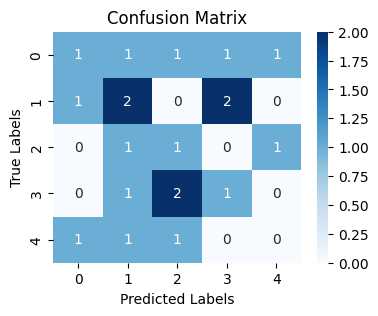

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.33      0.40      0.36         5
           2       0.20      0.33      0.25         3
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3

    accuracy                           0.25        20
   macro avg       0.22      0.24      0.22        20
weighted avg       0.25      0.25      0.24        20



In [ ]:
#Original Data
# XGBoost modelini oluştur
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_original_train_embeddings, y_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.35
F1-Score: 0.30


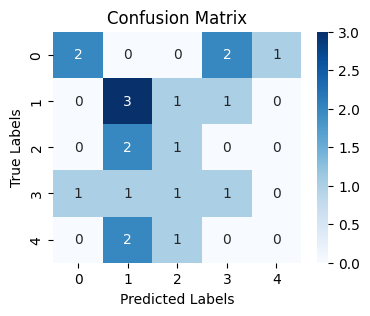

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.38      0.60      0.46         5
           2       0.25      0.33      0.29         3
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3

    accuracy                           0.35        20
   macro avg       0.31      0.32      0.30        20
weighted avg       0.35      0.35      0.33        20



In [ ]:
#2x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_2x_train_embeddings, y_2x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.40
F1-Score: 0.39


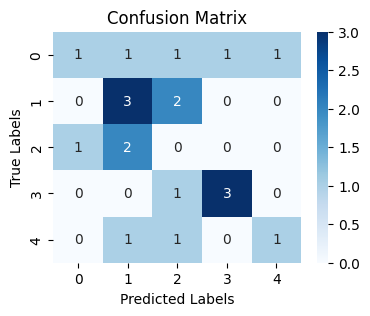

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.43      0.60      0.50         5
           2       0.00      0.00      0.00         3
           3       0.75      0.75      0.75         4
           4       0.50      0.33      0.40         3

    accuracy                           0.40        20
   macro avg       0.44      0.38      0.39        20
weighted avg       0.46      0.40      0.41        20



In [ ]:
#3x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_3x_train_embeddings, y_3x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:04:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.50
F1-Score: 0.42


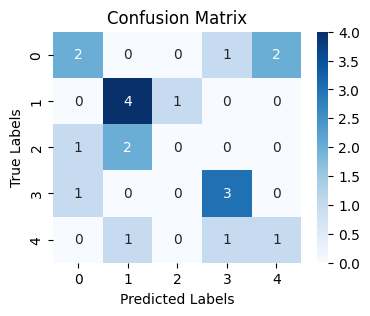

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.57      0.80      0.67         5
           2       0.00      0.00      0.00         3
           3       0.60      0.75      0.67         4
           4       0.33      0.33      0.33         3

    accuracy                           0.50        20
   macro avg       0.40      0.46      0.42        20
weighted avg       0.44      0.50      0.46        20



In [ ]:
#5x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_5x_train_embeddings, y_5x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))